## Video 1 : Session Overview
- reuse the model from week3

In [100]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

from collections import Counter
from tqdm.auto import tqdm

In [3]:
df = pd.read_csv('../week3/data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [7]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

## Video 2 : Session Overview
- Accuracy and Dummy Model

In [11]:
len(y_val)

1409

In [20]:
# y_val is an array of 0s and 1s and is compared to the churn_decision array containing predicted 0s and 1s
# mean of this comparison gives the accuracy
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

In [21]:
# same accuracy can be calculated using accuracy_score function from sklearn
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [19]:
# loop over different thresholds and calculate accuracy
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.513
0.10 0.608
0.15 0.661
0.20 0.703
0.25 0.735
0.30 0.758
0.35 0.765
0.40 0.781
0.45 0.791
0.50 0.803
0.55 0.802
0.60 0.796
0.65 0.789
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


- can be observed that threshold 0.5 gives the best accuracy

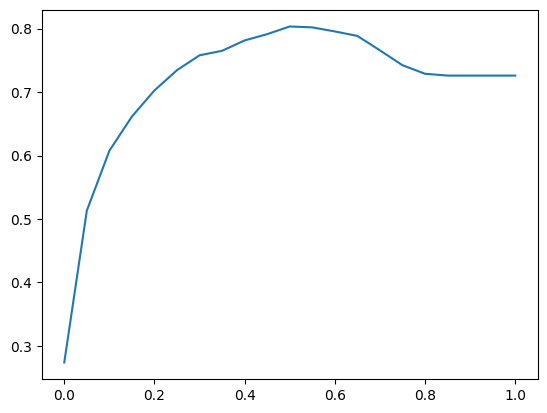

In [18]:
# plot the accuracy scores against the thresholds
plt.plot(thresholds, scores)

In [23]:
# count of false values in y_val
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

## Video 3 : Confusion Table
- Way of looking at different errors and correct predictions in a classification model
- This is viewed using a 2x2 table

### Churn logic
Given `t` as threshold and `g(x)` as predicted probability of churn for customer `x`:
- `g(x) >= t` => predict churn
- `g(x) < t` => predict no churn

### Prediction possibilities
1. **True Positive** : Model predicted customer will churn and they did
2. **False Positive** : Model predicted customer will churn but they didn't
3. **False Negative** : Model predicted customer will not churn but they did
4. **True Negative** : Model predicted customer will not churn and they didn't

In [24]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = 0.5
predicted_positive = (y_pred >= t)
predicted_negative = (y_pred < t)

In [25]:
tp = (predicted_positive & actual_positive).sum()
tn = (predicted_negative & actual_negative).sum()

fp = (predicted_positive & actual_negative).sum()
fn = (predicted_negative & actual_positive).sum()

In [27]:
confusion_matrix = np.array([[tn, fp],[fn, tp]])
confusion_matrix

array([[920, 103],
       [174, 212]])

In [28]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## Video 4 : Precision and Recall
1. Accuracy = (TP + TN) / (TP + TN + FP + FN)
2. Precision = TP / (TP + FP)
3. Recall = TP / (TP + FN)
4. F1Score = 2 * (Precision * Recall) / (Precision + Recall)

- Precision : out of all predicted positives, how many are actually positive
- Recall : out of all actual positives, how many are predicted positive

### Precision

In [35]:
p = tp / (tp + fp)
print('Precision: %.2f' % p)

Precision: 0.67


### Recall

In [34]:
r = tp / (tp + fn)
print('Recall: %.2f' % r)

Recall: 0.55


- It can be observed that precision is high but recall is low

## Video 5 : ROC Curves

### True Positive Rate (TPR) and False Positive Rate (FPR)

In [36]:
tpr = tp / (tp + fn)
print('True positive rate: %.2f' % tpr)

fpr = fp / (fp + tn)
print('False positive rate: %.2f' % fpr)

True positive rate: 0.55
False positive rate: 0.10


In [44]:
# for all thresholds, calculate tp, fp, fn, tn
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [45]:
df_scores = tpr_fpr_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,533,20,490,0.948187,0.521017
20,0.2,339,372,47,651,0.878238,0.363636
30,0.3,292,247,94,776,0.756477,0.241447
40,0.4,254,176,132,847,0.658031,0.172043
50,0.5,212,103,174,920,0.549223,0.100684
60,0.6,151,53,235,970,0.391192,0.051808
70,0.7,69,13,317,1010,0.178756,0.012708
80,0.8,4,0,382,1023,0.010363,0.000000
90,0.9,0,0,386,1023,0.000000,0.000000


In [46]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,533,20,490,0.948187,0.521017
20,0.2,339,372,47,651,0.878238,0.363636
30,0.3,292,247,94,776,0.756477,0.241447
40,0.4,254,176,132,847,0.658031,0.172043
50,0.5,212,103,174,920,0.549223,0.100684
60,0.6,151,53,235,970,0.391192,0.051808
70,0.7,69,13,317,1010,0.178756,0.012708
80,0.8,4,0,382,1023,0.010363,0.000000
90,0.9,0,0,386,1023,0.000000,0.000000


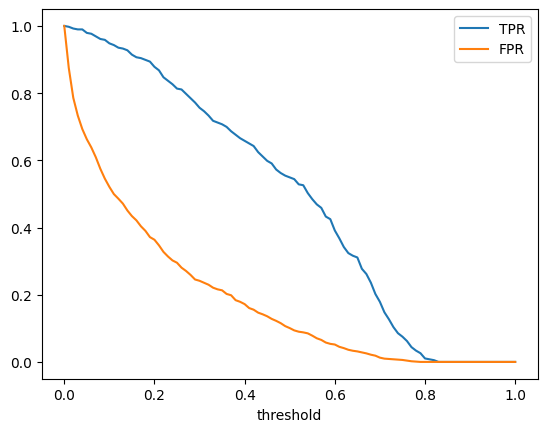

In [47]:
# plot tpr and fpr against thresholds
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.xlabel('threshold')
plt.legend()

### Random Model

In [43]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [48]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

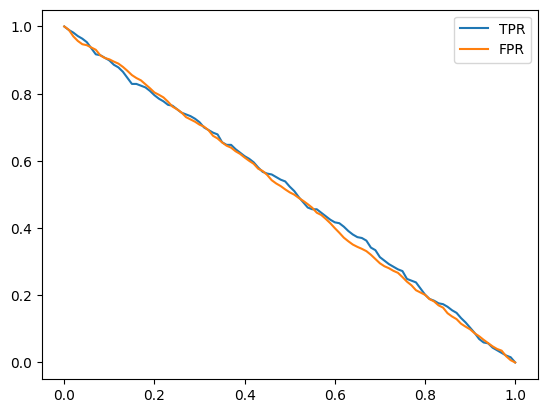

In [49]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

### Ideal model

In [54]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
print("Total number of samples: ", len(y_val))
print("----------------------------")
print("Number of negatives: ", num_neg)
print("Number of positives: ", num_pos)
print("----------------------------")
print("Churning customer percent: %.2f" % (num_pos / len(y_val)))
print("Non-churning customer percent: %.2f" % (num_neg / len(y_val)))

Total number of samples:  1409
----------------------------
Number of negatives:  1023
Number of positives:  386
----------------------------
Churning customer percent: 0.27
Non-churning customer percent: 0.73


In [55]:
# create ideal y_true and y_pred by repeating 0s and 1s as per counts of negatives and positives
y_ideal = np.repeat([0, 1], [num_neg, num_pos])

# create ideal y_pred as a linear space from 0 to 1
y_ideal_pred = np.linspace(0, 1, len(y_val))

# calculate 1 minus mean of y_val to get the non-churning customer percent
mean_ = 1 - y_val.mean()

# calculate accuracy score for ideal model at threshold equal to non-churning customer percent
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

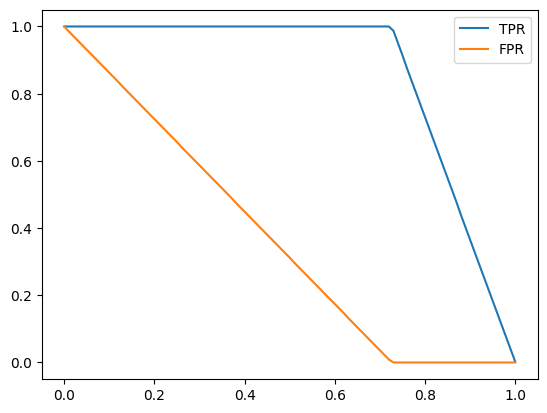

In [56]:
# get tpr and fpr for ideal model and plot them
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

### Plot all models

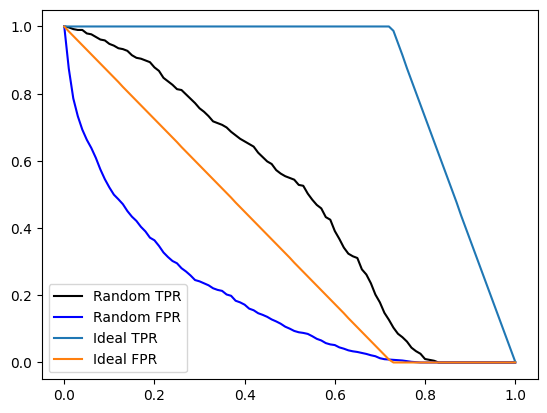

In [62]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='Random TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='Random FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='Ideal TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='Ideal FPR')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

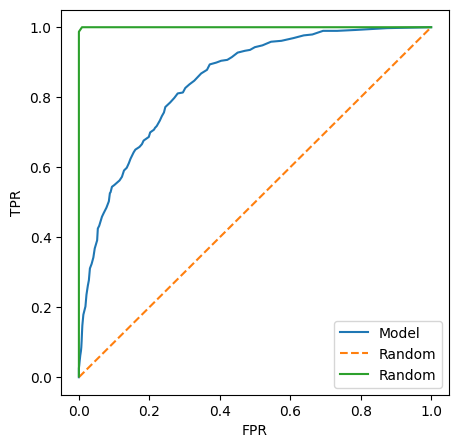

In [69]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')
plt.plot(df_ideal.fpr,df_ideal.tpr, label='Random')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

### using scikit to compute FPR, TPR

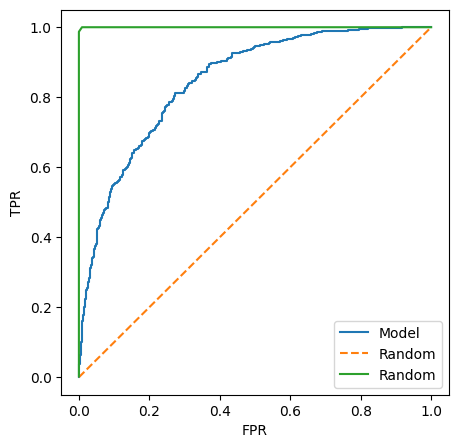

In [74]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')
plt.plot(df_ideal.fpr,df_ideal.tpr, label='Random')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## Video 6 : AUC
- Area under the ROC curve is called AUC
- AUC ranges from 0 to 1
- AUC can indicate how good the model is
- baselines
  - for random model, AUC is around 0.5
  - for ideal model, AUC is 1
  - for the created model the AUC could be in the 0.7-0.8 range and is considered a good model

In [75]:
auc(fpr, tpr)

0.8463753361797821

In [76]:
auc(df_scores.fpr, df_scores.tpr)

0.8459942058053374

In [77]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [78]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8463753361797821

In [81]:
roc_auc_score(y_val, y_pred)

0.8463753361797821

In [85]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

n = 100000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

random_score = success / n
print(random_score)


0.84676


In [88]:
n = 100000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.84519)

## Video 7 : Cross-Validation

In [96]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=10000)
    model.fit(X_train, y_train)

    return dv, model

dv, model = train(df_train, y_train, C=0.001)

In [97]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

y_pred = predict(df_val, dv, model)

In [98]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.008
C=0.1 0.842 +- 0.007
C=0.5 0.842 +- 0.007
C=1 0.842 +- 0.007
C=5 0.842 +- 0.007
C=10 0.842 +- 0.007


In [99]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.858373416967294